# ROS ALE Figure 6

Generates Figure 6 from the manuscript "Lab evolution and advanced data analytics reveal systems biology of ROS tolerance" by Kevin Rychel et al., 2022.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Generate-Figure" data-toc-modified-id="Generate-Figure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate Figure</a></span></li></ul></div>

## Set Up

In [1]:
# use py file to set up workspace
from src.ros_ale_functions import *

# load data
ica = load_json_model('input/precise1k_kr.json')
ros_meta = pd.read_csv('input/ros_ale_p1k_metadata.csv', index_col = 0)

## Generate Figure

Final rearrangement is performed and panel E is generated in Abode Illustrator.

/home/kevin/anaconda3/envs/py38env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kevin/anaconda3/envs/py38env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


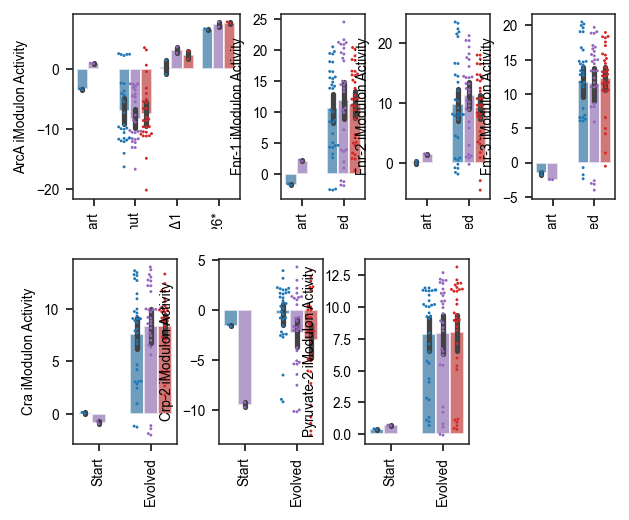

In [9]:
# layout for figure
fig = plt.figure(figsize = (5, 3.5), dpi = 140)
subfigs = fig.subfigures(2, 1)
top_axs = subfigs[0].subplots(1, 4, 
            gridspec_kw = {'width_ratios': [2, 1, 1, 1],
                           'wspace': 0.4})
btm_axs = subfigs[1].subplots(1, 4, 
            gridspec_kw = {'width_ratios': [1, 1, 1, 1],
                           'wspace': 0.4})
btm_axs[3].axis('off') # creates space for kgraph (panel E)

# draw plots
arcA_dict = {'Start':['0_0'],
             'No arcAB mut':['1_0', '1_2', '1_3', '1_4',
                       '2_0', '2_1', '2_2', '2_3', '3_0', 
                       '3_2', '3_3', '3_4'],
             'arcB Δ1':['3_1'],
             'arcA E26*':['1_1']}
im_bar_swarm(ica, ros_meta, 'ArcA', strain_dict = arcA_dict,
             ax = top_axs[0])

# iterate through all the Fnr iMs
for i in range(1, 4):
    im_bar_swarm(ica, ros_meta, 'Fnr-%i'%(i), ax = top_axs[i])
    
im_bar_swarm(ica, ros_meta, 'Cra', ax = btm_axs[0])
im_bar_swarm(ica, ros_meta, 'Crp-2', ax = btm_axs[1])
im_bar_swarm(ica, ros_meta, 'Pyruvate-2', ax = btm_axs[2])

plt.savefig('output/fig6_raw.pdf')